In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.data import *
from utils.datetime import convert_to_pd_timestamp
from utils.maps import (location_map, zurich_map, penumbra_map, compactness_map,
                        xray_class_map)
from utils.location import convert_location_to_cartesian

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,
                              RandomForestClassifier, GradientBoostingClassifier)
from sklearn.svm import SVR, SVC
from sklearn.metrics import (accuracy_score, mean_squared_error, r2_score, mean_absolute_error,
                             precision_score, recall_score, f1_score, confusion_matrix)

import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import GridSearchCV

2024-08-12 13:53:23.907629: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-12 13:53:23.908228: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-12 13:53:23.910305: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-12 13:53:23.915778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 13:53:23.925615: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
df = pd.read_csv("data/final-merged.csv")
df

,Date,Total Sunspot,Max Size,Zurich Class,Penumbra Class,Compactness Class,NS,Lat,EW,Lan,Flares Count,Avg Max Time,Max log10 X-ray intensity,Max Duration,Avg Duration,X-ray class,X-ray intensity
0,1982-01-01,18.0,430.0,D,K,O,S,25,W,75,0.0,0.000000e+00,0.000000,0.0,0.0,0,0.0
1,1982-01-01,2.0,280.0,H,S,X,S,21,W,84,0.0,0.000000e+00,0.000000,0.0,0.0,0,0.0
2,1982-01-01,11.0,240.0,D,A,O,N,20,W,73,2.0,3.787330e+08,-4.508638,3360.0,2340.0,M,3.1
3,1982-01-01,18.0,30.0,C,R,O,S,10,W,12,0.0,0.000000e+00,0.000000,0.0,0.0,0,0.0
4,1982-01-01,41.0,310.0,D,A,O,N,18,W,18,0.0,0.000000e+00,0.000000,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73387,2023-12-30,12.0,150.0,D,A,O,S,13,E,16,1.0,1.703920e+09,-5.721246,1800.0,1800.0,C,1.9
73388,2023-12-31,1.0,160.0,H,S,X,S,19,W,77,1.0,1.703991e+09,-5.920819,1560.0,1560.0,C,1.2
73389,2023-12-31,2.0,20.0,B,X,O,N,15,W,78,0.0,0.000000e+00,0.000000,0.0,0.0,0,0.0
73390,2023-12-31,10.0,120.0,D,A,O,S,12,E,3,0.0,0.000000e+00,0.000000,0.0,0.0,0,0.0


In [3]:
df['Date'] = df['Date'].apply(convert_to_pd_timestamp)

In [4]:
df['Is Flare'] = df['Flares Count'].apply(lambda _x: 1 if _x > 0 else 0)

# ML

In [5]:
# Encoding categorical columns: 'Zurich Class', 'Penumbra Class', 'Compactness Class'
label_encoders = {}
for col in ['Zurich Class', 'Penumbra Class', 'Compactness Class', 'NS', 'EW', 'X-ray class']:
  le = LabelEncoder()
  df[col] = le.fit_transform(df[col].astype(str))
  label_encoders[col] = le

def reverse_labelling(_df):
  # Reverse the label encoding
  for _col, _le in label_encoders.items():
    _df[_col] = _le.inverse_transform(_df[_col])
label_encoders

{'Zurich Class': LabelEncoder(),
 'Penumbra Class': LabelEncoder(),
 'Compactness Class': LabelEncoder(),
 'NS': LabelEncoder(),
 'EW': LabelEncoder(),
 'X-ray class': LabelEncoder()}

In [6]:
df.columns

Index(['Date', 'Total Sunspot', 'Max Size', 'Zurich Class', 'Penumbra Class',
       'Compactness Class', 'NS', 'Lat', 'EW', 'Lan', 'Flares Count',
       'Avg Max Time', 'Max log10 X-ray intensity', 'Max Duration',
       'Avg Duration', 'X-ray class', 'X-ray intensity', 'Is Flare'],
      dtype='object')

In [7]:
columns_for_x = ['Date', 'Total Sunspot', 'Max Size',
                 'Zurich Class', 'Penumbra Class', 'Compactness Class',
                 'NS', 'Lat', 'EW', 'Lan']

X = df[columns_for_x]
y_flares_count = df['Flares Count']
X_train, X_test, y_flares_count_train, y_flares_count_test = train_test_split(
  X, y_flares_count, test_size=0.2, random_state=42)

# Scaling features # todo: use if accuracy is low
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display the prepared data
df.head()

,Date,Total Sunspot,Max Size,Zurich Class,Penumbra Class,Compactness Class,NS,Lat,EW,Lan,Flares Count,Avg Max Time,Max log10 X-ray intensity,Max Duration,Avg Duration,X-ray class,X-ray intensity,Is Flare
0,378691200,18.0,430.0,4,3,3,1,25,1,75,0.0,0.0,0.000000,0.0,0.0,0,0.0,0
1,378691200,2.0,280.0,7,5,4,1,21,1,84,0.0,0.0,0.000000,0.0,0.0,0,0.0,0
2,378691200,11.0,240.0,4,1,3,0,20,1,73,2.0,378733020.0,-4.508638,3360.0,2340.0,4,3.1,1
3,378691200,18.0,30.0,3,4,3,1,10,1,12,0.0,0.0,0.000000,0.0,0.0,0,0.0,0
4,378691200,41.0,310.0,4,1,3,0,18,1,18,0.0,0.0,0.000000,0.0,0.0,0,0.0,0


In [8]:
models_dict = {
  "LR": LinearRegression,
  "LgR": LogisticRegression,  # classifier
  "DTR": DecisionTreeRegressor,
  "DTC": DecisionTreeClassifier,  # classifier
  "RFR": RandomForestRegressor,
  "RFC": RandomForestClassifier,  # classifier
  "SVR": SVR,
  "SVM": SVC,  # classifier
  "GBR": GradientBoostingRegressor,
  "GBC": GradientBoostingClassifier,  # classifier
}

def train_model(_model_key, _X_train, _y_train, **kwargs):
  if _model_key not in models_dict.keys():
    raise ValueError(f"Model for key `{_model_key}` not found! Available keys: {', '.join(models_dict.keys())}")
  
  model = models_dict[_model_key](**kwargs)
  model.fit(_X_train, _y_train)
  return model

def evaluate_model(_model, _X_test, _y_test):
  _predictions = _model.predict(_X_test)
  _mse = mean_squared_error(_y_test, _predictions)
  _mae = mean_absolute_error(_y_test, _predictions)
  _r2 = r2_score(_y_test, _predictions)
  print(f"MSE: {_mse}, MAE: {_mae}, R2 Score: {_r2}")
  return _mse, _mae, _r2

def evaluate_classification_model(_model, _X_test, _y_test, is_binary=True):
  _predictions = _model.predict(_X_test)
  _accuracy = accuracy_score(_y_test, _predictions)
  if is_binary:
    _precision = precision_score(_y_test, _predictions, zero_division=1)
    _recall = recall_score(_y_test, _predictions)
    _f1 = f1_score(_y_test, _predictions)
  else:
    _precision = precision_score(_y_test, _predictions, average='macro', zero_division=1)
    _recall = recall_score(_y_test, _predictions, average='macro')
    _f1 = f1_score(_y_test, _predictions, average='macro')
  _conf_matrix = confusion_matrix(_y_test, _predictions)
  return _accuracy, _precision, _recall, _f1, _conf_matrix

In [9]:
# lr_model_flares_count = train_model("LR", X_train, y_flares_count_train)
# evaluate_model(lr_model_flares_count, X_test, y_flares_count_test)

In [10]:
y_is_flare = df['Is Flare']
X_train, X_test, y_is_flare_train, y_is_flare_test = train_test_split(
  X, y_is_flare, test_size=0.2, random_state=42)

all_models_is_flare = {}

for mk in ["LgR", "DTC", "RFC", "SVM", "GBC"]:
  if mk == "SVM":
    model_is_flare = train_model(mk, X_train, y_is_flare_train, kernel='poly', degree=3)
  else:
    model_is_flare = train_model(mk, X_train, y_is_flare_train)
    
  all_models_is_flare[mk] = model_is_flare
  
  accuracy_is_flare, precision_is_flare, recall_is_flare, f1_is_flare, conf_matrix_is_flare = evaluate_classification_model(model_is_flare, X_test, y_is_flare_test)
  
  print(f"{mk}:: Accuracy:{round(accuracy_is_flare*100, 2)}, Precision: {round(precision_is_flare*100, 2)}, Recall: {round(recall_is_flare*100, 2)}, F1: {round(f1_is_flare*100, 2)}\n")

LgR:: Accuracy:79.48, Precision: 63.45, Recall: 26.86, F1: 37.74

DTC:: Accuracy:74.95, Precision: 46.3, Recall: 51.16, F1: 48.61
RFC:: Accuracy:82.53, Precision: 67.32, Recall: 47.75, F1: 55.87
SVM:: Accuracy:76.84, Precision: 100.0, Recall: 0.0, F1: 0.0
GBC:: Accuracy:82.8, Precision: 68.39, Recall: 47.81, F1: 56.28


| Model                            | Accuracy | Precision | Recall | Recall  |
|----------------------------------|----------|-----------|--------|---------|
| **Logistic Regression**          | 79.48    | 63.45     | 26.86  | 37.74   |
| **Decision Tree Classifier**     | 75.07    | 46.53     | 51.54  | 48.91   |
| **Random Forest Classifier**     | 82.52    | 67.32     | 47.63  | 55.79   |
| **Support Vector Machine**       | 76.84    | 100.00    | 0.00   | 0.00    |
| **Gradient Boosting Classifier** | 82.80    | 68.39     | 47.81  | 56.28   |


In [11]:
# Scaling features # todo: use if accuracy is low
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

all_models_is_flare_scaled = {}

for mk in ["LgR", "DTC", "RFC", "SVM", "GBC"]:
  model_is_flare = train_model(mk, X_train_scaled, y_is_flare_train)
  
  all_models_is_flare_scaled[mk] = model_is_flare
  
  accuracy_is_flare_scaled, precision_is_flare_scaled, recall_is_flare_scaled, f1_is_flare_scaled, conf_matrix_is_flare_scaled = evaluate_classification_model(model_is_flare, X_test_scaled, y_is_flare_test)

  print(f"{mk}:: Accuracy:{round(accuracy_is_flare_scaled*100, 2)}, Precision: {round(precision_is_flare_scaled*100, 2)}, Recall: {round(recall_is_flare_scaled*100, 2)}, F1: {round(f1_is_flare_scaled*100, 2)}\n")

LgR:: Accuracy:81.14, Precision: 69.51, Recall: 33.07, F1: 44.82
DTC:: Accuracy:75.07, Precision: 46.5, Recall: 50.81, F1: 48.56
RFC:: Accuracy:82.42, Precision: 67.07, Recall: 47.28, F1: 55.46
SVM:: Accuracy:81.63, Precision: 67.69, Recall: 39.57, F1: 49.94
GBC:: Accuracy:82.8, Precision: 68.39, Recall: 47.81, F1: 56.28


In [12]:
def build_and_train_lstm(_X_train, _y_train, _X_test, _y_test,
                         _epochs=50, _batch_size=32):
  # Reshape input to be 3D [samples, timesteps, features]
  X_train_lstm = np.expand_dims(_X_train, axis=1)
  X_test_lstm = np.expand_dims(_X_test, axis=1)

  model = Sequential()
  model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(50, return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy',])

  model.fit(X_train_lstm, _y_train, validation_data=(X_test_lstm, _y_test), epochs=_epochs, batch_size=_batch_size)

  return model

def build_and_train_cnn(_X_train, _y_train, _X_test, _y_test,
                         _epochs=50, _batch_size=32):
  # Reshape input to be 3D [samples, timesteps, features] for CNN
  X_train_cnn = np.expand_dims(_X_train, axis=2)
  X_test_cnn = np.expand_dims(_X_test, axis=2)

  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(50, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy',])

  model.fit(X_train_cnn, _y_train, validation_data=(X_test_cnn, _y_test), epochs=_epochs, batch_size=_batch_size)

  return model

In [13]:
lstm_model1 = build_and_train_lstm(X_train_scaled, y_is_flare_train,
                                  X_test_scaled, y_is_flare_test,
                                  _epochs=50, _batch_size=32)

I0000 00:00:1723467436.596852  292054 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-12 13:57:16.778816: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/debashis/works/dissertation/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8056 - loss: 0.4638 - val_accuracy: 0.8173 - val_loss: 0.4096
Epoch 2/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8172 - loss: 0.4139 - val_accuracy: 0.8178 - val_loss: 0.4101
Epoch 3/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8197 - loss: 0.4114 - val_accuracy: 0.8174 - val_loss: 0.4084
Epoch 4/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8209 - loss: 0.4089 - val_accuracy: 0.8167 - val_loss: 0.4084
Epoch 5/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8204 - loss: 0.4069 - val_accuracy: 0.8185 - val_loss: 0.4077
Epoch 6/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8207 - loss: 0.4070 - val_accuracy: 0.8174 - val_loss: 0.4074
Epoch 7/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8215 - loss: 0.4036 - val_accuracy: 0.8187 - val_loss: 0.4077
Epoch 8/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8184 - loss: 0.4097 -

In [14]:
cnn_model1 = build_and_train_cnn(X_train_scaled, y_is_flare_train,
                                  X_test_scaled, y_is_flare_test,
                                  _epochs=50, _batch_size=32)

/home/debashis/works/dissertation/env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.8080 - loss: 0.4331 - val_accuracy: 0.8148 - val_loss: 0.4179
Epoch 2/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8141 - loss: 0.4196 - val_accuracy: 0.8158 - val_loss: 0.4159
Epoch 3/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8126 - loss: 0.4190 - val_accuracy: 0.8164 - val_loss: 0.4156
Epoch 4/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8167 - loss: 0.4159 - val_accuracy: 0.8158 - val_loss: 0.4158
Epoch 5/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.8171 - loss: 0.4152 - val_accuracy: 0.8170 - val_loss: 0.4130
Epoch 6/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8148 - loss: 0.4189 - val_accuracy: 0.8173 - val_loss: 0.4118
Epoch 7/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8196 - loss: 0.4108 - val_accuracy: 0.8163 - val_loss: 0.4119
Epoch 8/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.8165 - loss: 0

In [15]:
all_models_is_flare_scaled["LSTM"] = lstm_model1
all_models_is_flare_scaled["CNN"] = cnn_model1

In [16]:
def nn_evaluate_model(_model, _X_test, _y_test, _axis=1):
  _X_test = np.expand_dims(_X_test, axis=_axis)
  # Predict probabilities
  _y_pred_prob = _model.predict(_X_test)
  # Convert probabilities to binary predictions
  _y_pred = (_y_pred_prob > 0.5).astype("int32")

  # Calculate metrics
  _accuracy = accuracy_score(_y_test, _y_pred)
  _precision = precision_score(_y_test, _y_pred, zero_division=1)
  _recall = recall_score(_y_test, _y_pred)
  _f1 = f1_score(_y_test, _y_pred)

  return _accuracy, _precision, _recall, _f1

In [17]:
lstm_accuracy, lstm_precision, lstm_recall, lstm_f1 = nn_evaluate_model(lstm_model1, X_test_scaled,
                                                                        y_is_flare_test)
cnn_accuracy, cnn_precision, cnn_recall, cnn_f1 = nn_evaluate_model(cnn_model1, X_test_scaled,
                                                                    y_is_flare_test, 2)
lstm_accuracy, lstm_precision, lstm_recall, lstm_f1, cnn_accuracy, cnn_precision, cnn_recall, cnn_f1

459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


(0.820287485523537,
 0.6599411517444305,
 0.46190055898793764,
 0.5434406368985808,
 0.8192656175488794,
 0.6833824975417896,
 0.40894380700205946,
 0.5116878336094239)

## Scaled

| Model                              | Accuracy | Precision | Recall  | F1    |
|------------------------------------|----------|-----------|---------|-------|
| ~~Logistic Regression~~            | 81.14    | 69.51     | 33.07   | 44.82 |
| ~~Decision Tree Classifier~~       | 75.01    | 46.42     | 51.31   | 48.74 |
| **2.Random Forest Classifier**     | 82.51    | 67.11     | 47.96   | 55.94 |
| ~~Support Vector Machine~~         | 81.63    | 67.69     | 39.57   | 49.94 |
| **1.Gradient Boosting Classifier** | 82.80    | 68.39     | 47.81   | 56.28 |
| **3.LSTM**                         | 81.89    | 65.96     | 45.04   | 53.53 |
| ~~CNN~~                            | 81.95    | 68.77     | 40.36   | 50.87 |

In [18]:
df.columns

Index(['Date', 'Total Sunspot', 'Max Size', 'Zurich Class', 'Penumbra Class',
       'Compactness Class', 'NS', 'Lat', 'EW', 'Lan', 'Flares Count',
       'Avg Max Time', 'Max log10 X-ray intensity', 'Max Duration',
       'Avg Duration', 'X-ray class', 'X-ray intensity', 'Is Flare'],
      dtype='object')

In [19]:
# _for_test = 

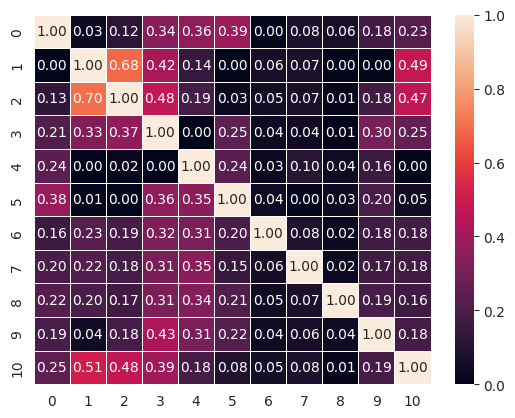

In [20]:
sns.heatmap(MinMaxScaler().fit_transform(df.drop(['Flares Count', 'Avg Max Time', 'Max log10 X-ray intensity',
                     'Max Duration', 'Avg Duration', 'X-ray class',
                     'X-ray intensity'], axis=1).corr()), annot=True, fmt='.2f', linewidths=0.5)
plt.show()

In [ ]:
# plt.figure(figsize=(10, 6))
# pd.plotting.andrews_curves(df.drop(['Flares Count', 'Avg Max Time', 'Max log10 X-ray intensity',
#                      'Max Duration', 'Avg Duration', 'X-ray class',
#                      'X-ray intensity'], axis=1), 'Is Flare', colormap="viridis")
# plt.legend(['No flare', 'Significant Flare'])
# plt.grid(True)
# plt.show()

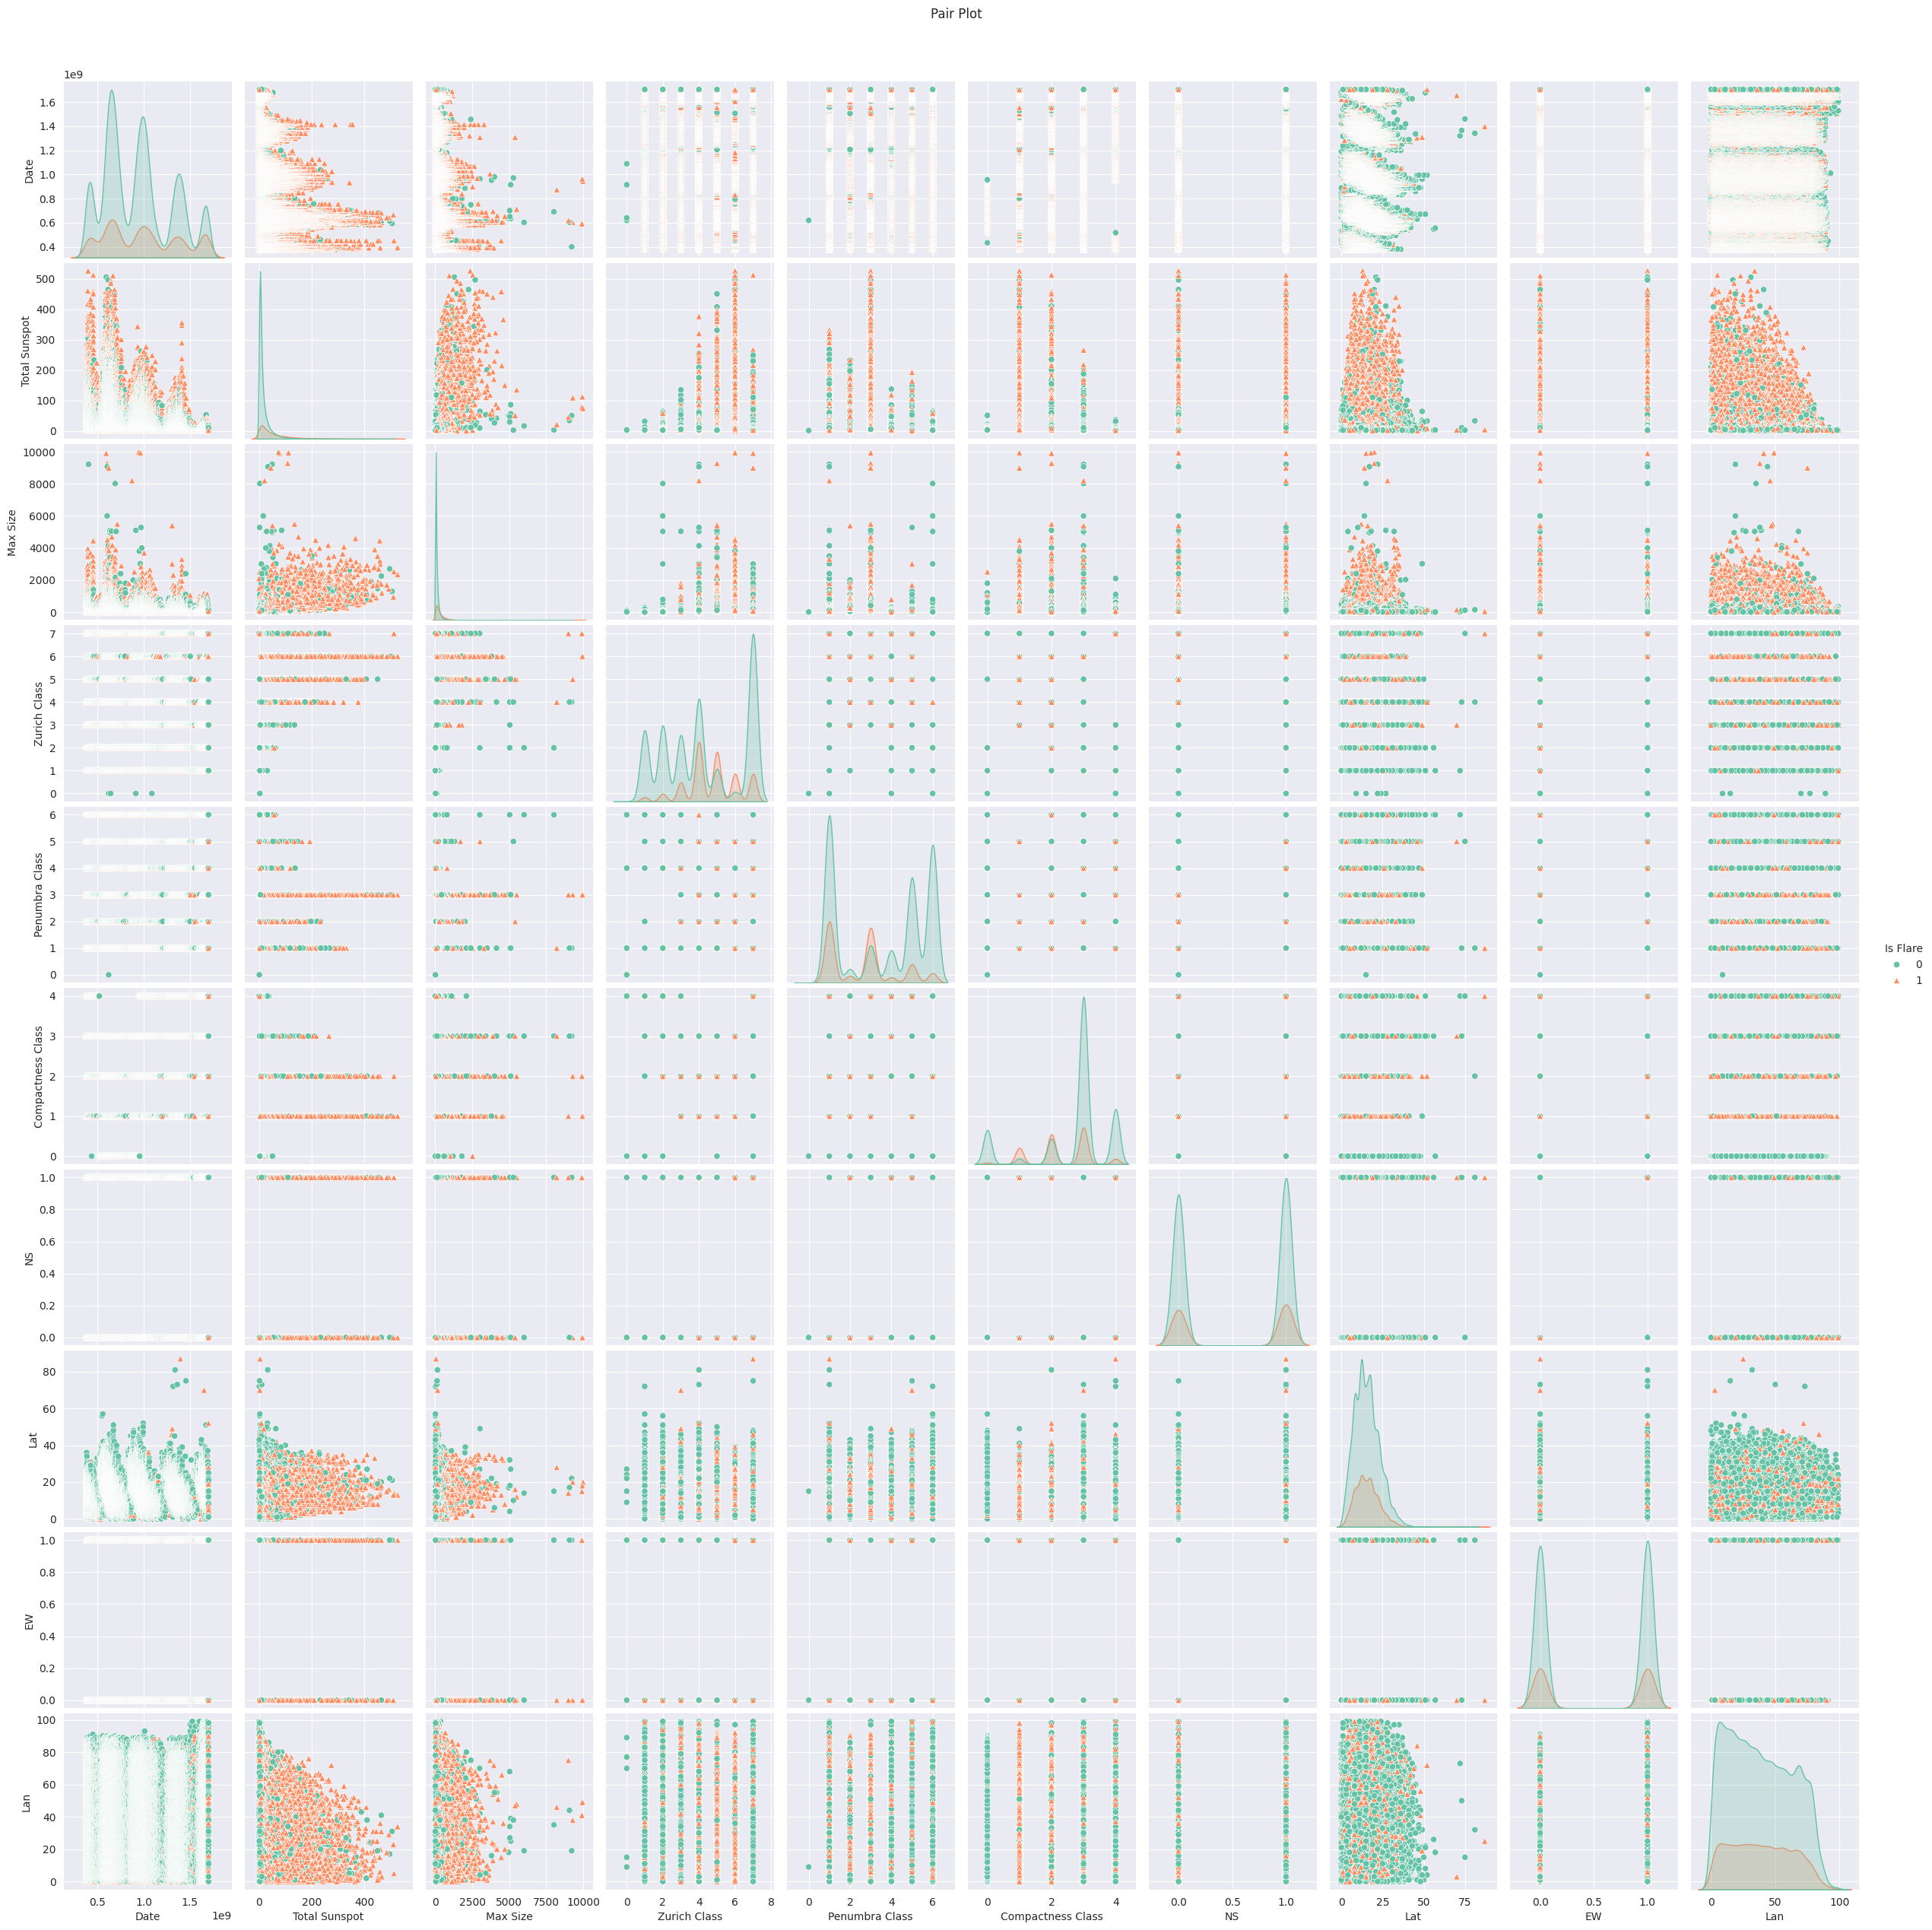

In [22]:
sns.pairplot(df.drop(['Flares Count', 'Avg Max Time', 'Max log10 X-ray intensity',
                     'Max Duration', 'Avg Duration', 'X-ray class',
                     'X-ray intensity'], axis=1), hue='Is Flare', markers=["o", "^"], palette="Set2")
plt.suptitle("Pair Plot", y=1.02)
plt.show()

/tmp/ipykernel_292054/3661074249.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=all_models_is_flare_scaled['GBC'].feature_importances_,


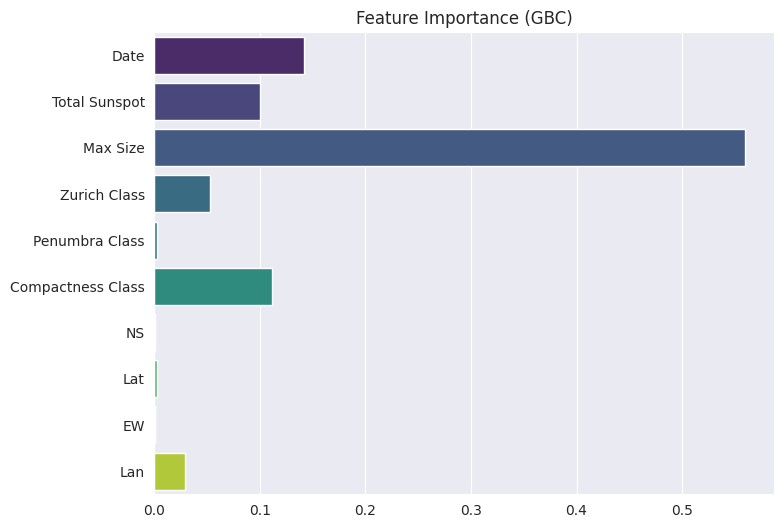

In [23]:
plt.figure(figsize=(8, 6))
sns.barplot(x=all_models_is_flare_scaled['GBC'].feature_importances_,
            y=['Date', 'Total Sunspot', 'Max Size', 'Zurich Class',
               'Penumbra Class', 'Compactness Class', 'NS', 'Lat', 'EW', 'Lan'], palette="viridis")
plt.title("Feature Importance (GBC)")
plt.show()

/tmp/ipykernel_292054/680843557.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=all_models_is_flare_scaled['RFC'].feature_importances_,


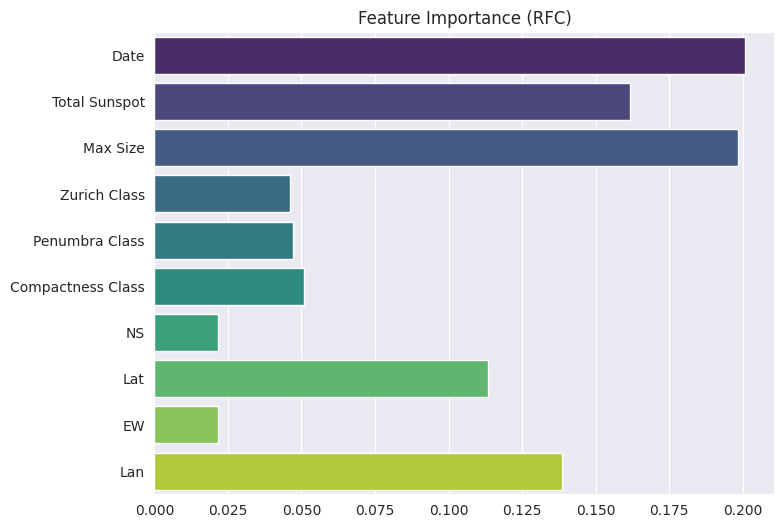

In [24]:
plt.figure(figsize=(8, 6))
sns.barplot(x=all_models_is_flare_scaled['RFC'].feature_importances_,
            y=['Date', 'Total Sunspot', 'Max Size', 'Zurich Class',
               'Penumbra Class', 'Compactness Class', 'NS', 'Lat', 'EW', 'Lan'], palette="viridis")
plt.title("Feature Importance (RFC)")
plt.show()

In [25]:
# Scaling features
X_no_loc = df[columns_for_x[:6]]
X_train_no_loc, X_test_no_loc, y_is_flare_train_no_loc, y_is_flare_test_no_loc = train_test_split(
  X_no_loc, y_is_flare, test_size=0.2, random_state=42)

scaler_no_loc = StandardScaler()
X_train_no_loc_scaled = scaler_no_loc.fit_transform(X_train_no_loc)
X_test_no_loc_scaled = scaler_no_loc.transform(X_test_no_loc)

all_models_is_flare_no_loc_scaled = {}

for mk in ["LgR", "DTC", "RFC", "SVM", "GBC"]:
  model_is_flare_no_loc = train_model(mk, X_train_no_loc_scaled, y_is_flare_train_no_loc)
  
  all_models_is_flare_no_loc_scaled[mk] = model_is_flare_no_loc
  
  accuracy_is_flare_scaled, precision_is_flare_scaled, recall_is_flare_scaled, f1_is_flare_scaled, conf_matrix_is_flare_scaled = evaluate_classification_model(
    model_is_flare_no_loc, X_test_no_loc_scaled, y_is_flare_test_no_loc)

  print(f"{mk}:: Accuracy:{round(accuracy_is_flare_scaled*100, 2)}, Precision: {round(precision_is_flare_scaled*100, 2)}, Recall: {round(recall_is_flare_scaled*100, 2)}, F1: {round(f1_is_flare_scaled*100, 2)}\n")

LgR:: Accuracy:81.0, Precision: 69.21, Recall: 32.33, F1: 44.07

DTC:: Accuracy:75.78, Precision: 47.79, Recall: 49.54, F1: 48.65
RFC:: Accuracy:80.18, Precision: 58.91, Recall: 47.54, F1: 52.62
SVM:: Accuracy:81.69, Precision: 66.7, Recall: 41.78, F1: 51.37
GBC:: Accuracy:82.27, Precision: 67.2, Recall: 45.75, F1: 54.44


In [26]:
all_models_is_flare_no_loc = {}

for mk in ["LgR", "DTC", "RFC", "SVM", "GBC"]:
  model_is_flare_no_loc = train_model(mk, X_train_no_loc, y_is_flare_train_no_loc)
  
  all_models_is_flare_no_loc[mk] = model_is_flare_no_loc
  
  accuracy_is_flare, precision_is_flare, recall_is_flare, f1_is_flare, conf_matrix_is_flare = evaluate_classification_model(
    model_is_flare_no_loc, X_test_no_loc, y_is_flare_test_no_loc)

  print(f"{mk}:: Accuracy:{round(accuracy_is_flare*100, 2)}, Precision: {round(precision_is_flare*100, 2)}, Recall: {round(recall_is_flare*100, 2)}, F1: {round(f1_is_flare*100, 2)}\n")

LgR:: Accuracy:79.47, Precision: 63.44, Recall: 26.8, F1: 37.68

DTC:: Accuracy:75.48, Precision: 47.17, Recall: 49.22, F1: 48.17
RFC:: Accuracy:79.96, Precision: 58.39, Recall: 46.9, F1: 52.02
SVM:: Accuracy:76.84, Precision: 100.0, Recall: 0.0, F1: 0.0
GBC:: Accuracy:82.27, Precision: 67.2, Recall: 45.75, F1: 54.44


In [27]:
_test_dtc_model = models_dict["RFC"]()
_test_dtc_model.fit(X_train_no_loc_scaled, y_is_flare_train_no_loc)
# _test_prd = _test_dtc_model.predict(X_test_no_loc_scaled)

_test_accuracy_is_flare, _test_precision_is_flare, _test_recall_is_flare, _test_f1_is_flare, _test_conf_matrix_is_flare = evaluate_classification_model(
    _test_dtc_model, X_test_no_loc_scaled, y_is_flare_test_no_loc)
f"Accuracy:{round(_test_accuracy_is_flare*100, 2)}, Precision: {round(_test_precision_is_flare*100, 2)}, Recall: {round(_test_recall_is_flare*100, 2)}, F1: {round(_test_f1_is_flare*100, 2)}\n"

'Accuracy:79.75, Precision: 57.78, Recall: 46.66, F1: 51.63\n'

In [28]:
lstm_model2 = build_and_train_lstm(X_train_no_loc_scaled, y_is_flare_train_no_loc,
                                  X_test_no_loc_scaled, y_is_flare_test_no_loc,
                                  _epochs=50, _batch_size=32)

Epoch 1/50


/home/debashis/works/dissertation/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1835/1835 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8070 - loss: 0.4586 - val_accuracy: 0.8161 - val_loss: 0.4151
Epoch 2/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8158 - loss: 0.4153 - val_accuracy: 0.8173 - val_loss: 0.4152
Epoch 3/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8165 - loss: 0.4179 - val_accuracy: 0.8180 - val_loss: 0.4136
Epoch 4/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8176 - loss: 0.4148 - val_accuracy: 0.8183 - val_loss: 0.4143
Epoch 5/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8178 - loss: 0.4108 - val_accuracy: 0.8167 - val_loss: 0.4135
Epoch 6/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8167 - loss: 0.4146 - val_accuracy: 0.8180 - val_loss: 0.4129
Epoch 7/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8178 - loss: 0.4128 - val_accuracy: 0.8175 - val_loss: 0.4129
Epoch 8/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8203 - loss: 0.4113 - val_accurac

In [29]:
cnn_model2 = build_and_train_cnn(X_train_no_loc_scaled, y_is_flare_train_no_loc,
                                 X_test_no_loc_scaled, y_is_flare_test_no_loc,
                                 _epochs=50, _batch_size=32)

Epoch 1/50


/home/debashis/works/dissertation/env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1835/1835 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8061 - loss: 0.4383 - val_accuracy: 0.8116 - val_loss: 0.4195
Epoch 2/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8144 - loss: 0.4155 - val_accuracy: 0.8134 - val_loss: 0.4169
Epoch 3/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8111 - loss: 0.4230 - val_accuracy: 0.8127 - val_loss: 0.4204
Epoch 4/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8129 - loss: 0.4182 - val_accuracy: 0.8136 - val_loss: 0.4162
Epoch 5/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8087 - loss: 0.4258 - val_accuracy: 0.8131 - val_loss: 0.4153
Epoch 6/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8151 - loss: 0.4151 - val_accuracy: 0.8144 - val_loss: 0.4143
Epoch 7/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8144 - loss: 0.4177 - val_accuracy: 0.8150 - val_loss: 0.4135
Epoch 8/50
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8178 - loss: 0.4106 - val_accurac

In [39]:
{index: label for index, label in enumerate(label_encoders['X-ray class'].classes_)}

{0: '0', 1: 'A', 2: 'B', 3: 'C', 4: 'M', 5: 'X'}

In [40]:
df['Flare Type'] = df['X-ray class'].map({
  0: 0,  # No flare
  1: 1,  # A
  2: 1,  # B
  3: 1,  # C
  4: 2,  # M -> Significant Flare
  5: 2   # X -> Significant Flare
})

In [44]:
y_flares_type = df['Flare Type']
X_train, X_test, y_train_flares_type, y_test_flares_type = train_test_split(
  X, y_flares_type, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [47]:
all_models_flare_type = {}

for mk in ["LgR", "DTC", "RFC", "SVM", "GBC"]:
  if mk == "SVM":
    model_flare_type = train_model(mk, X_train, y_train_flares_type, kernel='poly', degree=3)
  else:
    model_flare_type = train_model(mk, X_train, y_train_flares_type)
    
  all_models_flare_type[mk] = model_flare_type
  
  __accuracy, __precision, __recall, __f1, __conf_matrix = evaluate_classification_model(model_flare_type, X_test, y_test_flares_type, False)
  
  print(f"{mk}:: Accuracy:{round(__accuracy*100, 2)}, Precision: {round(__precision*100, 2)}, Recall: {round(__recall*100, 2)}, F1: {round(__f1*100, 2)}\n")

LgR:: Accuracy:77.53, Precision: 55.54, Recall: 40.16, F1: 41.51
DTC:: Accuracy:71.65, Precision: 47.5, Recall: 48.46, F1: 47.94
RFC:: Accuracy:80.04, Precision: 64.34, Recall: 49.97, F1: 53.7
SVM:: Accuracy:76.84, Precision: 92.28, Recall: 33.33, F1: 28.97
GBC:: Accuracy:80.0, Precision: 62.5, Recall: 48.37, F1: 51.66


In [49]:
# only_flares_df = df[df['Is Flare'] != 0]
X = df[columns_for_x]
y_flares_type = df['Flare Type']
X_train, X_test, y_train_flares_type, y_test_flares_type = train_test_split(
  X, y_flares_type, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

all_models_flare_type2 = {}

for mk in ["LgR", "DTC", "RFC", "SVM", "GBC"]:
  if mk == "SVM":
    model_flare_type = train_model(mk, X_train, y_train_flares_type, kernel='poly', degree=3)
  else:
    model_flare_type = train_model(mk, X_train, y_train_flares_type)
    
  all_models_flare_type2[mk] = model_flare_type
  
  __accuracy, __precision, __recall, __f1, __conf_matrix = evaluate_classification_model(model_flare_type, X_test, y_test_flares_type, False)
  
  print(f"{mk}:: Accuracy:{round(__accuracy*100, 2)}, Precision: {round(__precision*100, 2)}, Recall: {round(__recall*100, 2)}, F1: {round(__f1*100, 2)}\n")

LgR:: Accuracy:80.8, Precision: 70.54, Recall: 54.39, F1: 53.54

DTC:: Accuracy:74.12, Precision: 59.41, Recall: 59.45, F1: 59.43
RFC:: Accuracy:81.94, Precision: 73.14, Recall: 59.47, F1: 61.18
SVM:: Accuracy:80.13, Precision: 90.06, Recall: 50.0, F1: 44.48
GBC:: Accuracy:81.79, Precision: 73.42, Recall: 58.27, F1: 59.56


In [ ]:
df['Location'] = np.where(df['NS'] == 1, 'S', 'N') + df['Lat'].astype(str).str.zfill(2) + \
                 np.where(df['EW'] == 1, 'W', 'E') + df['Lan'].astype(str).str.zfill(2)
df[['Location X', 'Location Y', 'Location Z']] = df['Location'].apply(lambda loc: pd.Series(convert_location_to_cartesian(loc)))
df.drop('Location', axis=1, inplace=True)

In [71]:
only_flares_df = df[df['Is Flare'] != 0]
X = only_flares_df[['Date', 'Total Sunspot', 'Max Size', 'Zurich Class',
        'Penumbra Class', 'Compactness Class', 'Location X', 'Location Y', 'Location Z']]

y_flares_type = only_flares_df['Flare Type']
X_train, X_test, y_train_flares_type, y_test_flares_type = train_test_split(
  X, y_flares_type, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

all_models_flare_type2 = {}

for mk in ["LgR", "DTC", "RFC", "GBC", "SVM"]:
  model_flare_type = train_model(mk, X_train_scaled, y_train_flares_type)
    
  all_models_flare_type2[mk] = model_flare_type
  
  __accuracy, __precision, __recall, __f1, __conf_matrix = evaluate_classification_model(model_flare_type, X_test_scaled, y_test_flares_type, False)
  
  print(f"{mk}:: Accuracy:{round(__accuracy*100, 2)}, Precision: {round(__precision*100, 2)}, Recall: {round(__recall*100, 2)}, F1: {round(__f1*100, 2)}\n")

LgR:: Accuracy:81.27, Precision: 72.84, Recall: 55.73, F1: 55.72

DTC:: Accuracy:74.73, Precision: 59.76, Recall: 59.39, F1: 59.56
RFC:: Accuracy:81.82, Precision: 72.78, Recall: 59.17, F1: 60.78
GBC:: Accuracy:81.88, Precision: 74.23, Recall: 58.05, F1: 59.24
SVM:: Accuracy:81.18, Precision: 75.74, Recall: 54.13, F1: 52.87


In [73]:
df['Year'] = pd.to_datetime(df['Date'], unit='s').dt.year
df['Month'] = pd.to_datetime(df['Date'], unit='s').dt.month
df['Day'] = pd.to_datetime(df['Date'], unit='s').dt.day

In [76]:
only_flares_df = df[df['Is Flare'] != 0]
X = only_flares_df[['Year', 'Month', 'Day', 'Total Sunspot', 'Max Size', 'Zurich Class',
        'Penumbra Class', 'Compactness Class', 'Location X', 'Location Y', 'Location Z']]

y_flares_type = only_flares_df['Flare Type']
X_train, X_test, y_train_flares_type, y_test_flares_type = train_test_split(
  X, y_flares_type, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

all_models_flare_type2 = {}

for mk in ["LgR", "DTC", "RFC", "GBC", "SVM"]:
  model_flare_type = train_model(mk, X_train_scaled, y_train_flares_type)
    
  all_models_flare_type2[mk] = model_flare_type
  
  __accuracy, __precision, __recall, __f1, __conf_matrix = evaluate_classification_model(model_flare_type, X_test_scaled, y_test_flares_type, False)
  
  print(f"{mk}:: Accuracy:{round(__accuracy*100, 2)}, Precision: {round(__precision*100, 2)}, Recall: {round(__recall*100, 2)}, F1: {round(__f1*100, 2)}\n")

LgR:: Accuracy:81.12, Precision: 71.75, Recall: 55.64, F1: 55.61

DTC:: Accuracy:73.8, Precision: 59.31, Recall: 59.58, F1: 59.44
RFC:: Accuracy:82.29, Precision: 75.08, Recall: 59.46, F1: 61.22
GBC:: Accuracy:81.32, Precision: 71.88, Recall: 56.88, F1: 57.54
SVM:: Accuracy:80.92, Precision: 73.59, Recall: 53.58, F1: 51.94


In [77]:
X = only_flares_df[['Year', 'Month', 'Day', 'Total Sunspot', 'Max Size', 'Zurich Class',
                    'Penumbra Class', 'Compactness Class',
                    'NS', 'Lat', 'EW', 'Lan']]
y_is_flare = only_flares_df['Flare Type']
X_train, X_test, y_is_flare_train, y_is_flare_test = train_test_split(
  X, y_is_flare, test_size=0.2, random_state=42)

all_models_is_flare = {}

for mk in ["LgR", "DTC", "RFC", "SVM", "GBC"]:
  if mk == "SVM":
    model_is_flare = train_model(mk, X_train, y_is_flare_train, kernel='poly', degree=3)
  else:
    model_is_flare = train_model(mk, X_train, y_is_flare_train)
    
  all_models_is_flare[mk] = model_is_flare
  
  accuracy_is_flare, precision_is_flare, recall_is_flare, f1_is_flare, conf_matrix_is_flare = evaluate_classification_model(model_is_flare, X_test, y_is_flare_test)
  
  print(f"{mk}:: Accuracy:{round(accuracy_is_flare*100, 2)}, Precision: {round(precision_is_flare*100, 2)}, Recall: {round(recall_is_flare*100, 2)}, F1: {round(f1_is_flare*100, 2)}\n")

/home/debashis/works/dissertation/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LgR:: Accuracy:81.12, Precision: 81.91, Recall: 98.11, F1: 89.28

DTC:: Accuracy:73.83, Precision: 83.15, Recall: 84.45, F1: 83.79
RFC:: Accuracy:82.35, Precision: 83.44, Recall: 97.27, F1: 89.83
SVM:: Accuracy:80.54, Precision: 80.64, Recall: 99.64, F1: 89.14
GBC:: Accuracy:81.88, Precision: 82.74, Recall: 97.78, F1: 89.63


In [79]:
X = df[['Year', 'Month', 'Day', 'Total Sunspot', 'Max Size', 'Zurich Class',
                    'Penumbra Class', 'Compactness Class',
                    'NS', 'Lat', 'EW', 'Lan']]
y_is_flare = df['Flare Type']
X_train, X_test, y_is_flare_train, y_is_flare_test = train_test_split(
  X, y_is_flare, test_size=0.2, random_state=42)

all_models_is_flare = {}

for mk in ["LgR", "DTC", "RFC", "GBC"]:
  model_is_flare = train_model(mk, X_train, y_is_flare_train)
    
  all_models_is_flare[mk] = model_is_flare
  
  accuracy_is_flare, precision_is_flare, recall_is_flare, f1_is_flare, conf_matrix_is_flare = evaluate_classification_model(model_is_flare, X_test, y_is_flare_test, False)
  
  print(f"{mk}:: Accuracy:{round(accuracy_is_flare*100, 2)}, Precision: {round(precision_is_flare*100, 2)}, Recall: {round(recall_is_flare*100, 2)}, F1: {round(f1_is_flare*100, 2)}\n")

/home/debashis/works/dissertation/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LgR:: Accuracy:78.47, Precision: 60.34, Recall: 41.79, F1: 43.85
DTC:: Accuracy:71.25, Precision: 47.51, Recall: 48.44, F1: 47.92
RFC:: Accuracy:79.98, Precision: 63.18, Recall: 48.78, F1: 52.29
GBC:: Accuracy:79.88, Precision: 62.99, Recall: 48.19, F1: 51.49


In [80]:
X = df[['Year', 'Month', 'Day', 'Total Sunspot', 'Max Size', 'Zurich Class',
                    'Penumbra Class', 'Compactness Class',
                    'NS', 'Lat', 'EW', 'Lan']]
y_is_flare = df['Is Flare']
X_train, X_test, y_is_flare_train, y_is_flare_test = train_test_split(
  X, y_is_flare, test_size=0.2, random_state=42)

all_models_is_flare = {}

for mk in ["LgR", "DTC", "RFC", "GBC"]:
  model_is_flare = train_model(mk, X_train, y_is_flare_train)
    
  all_models_is_flare[mk] = model_is_flare
  
  accuracy_is_flare, precision_is_flare, recall_is_flare, f1_is_flare, conf_matrix_is_flare = evaluate_classification_model(model_is_flare, X_test, y_is_flare_test)
  
  print(f"{mk}:: Accuracy:{round(accuracy_is_flare*100, 2)}, Precision: {round(precision_is_flare*100, 2)}, Recall: {round(recall_is_flare*100, 2)}, F1: {round(f1_is_flare*100, 2)}\n")

/home/debashis/works/dissertation/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LgR:: Accuracy:80.69, Precision: 70.05, Recall: 29.04, F1: 41.06
DTC:: Accuracy:74.81, Precision: 45.86, Recall: 48.78, F1: 47.28
RFC:: Accuracy:82.59, Precision: 67.78, Recall: 47.34, F1: 55.74
GBC:: Accuracy:82.66, Precision: 68.23, Recall: 47.01, F1: 55.67


In [90]:
scaler = MinMaxScaler()
df_normalized = df[['Date', 'Year', 'Month', 'Day', 'Total Sunspot',
                    'Max Size', 'Zurich Class', 'Penumbra Class',
                    'Compactness Class', 'Location X', 'Location Y', 'Location Z',
                    'NS', 'Lat', 'EW', 'Lan']]
df_normalized = pd.DataFrame(scaler.fit_transform(df_normalized), columns=df_normalized.columns)

In [92]:
X = df_normalized[['Year', 'Month', 'Day', 'Total Sunspot', 'Max Size', 'Zurich Class',
        'Penumbra Class', 'Compactness Class', 'Location X', 'Location Y', 'Location Z']]

y_flares_type = df['Flare Type']
X_train, X_test, y_train_flares_type, y_test_flares_type = train_test_split(
  X, y_flares_type, test_size=0.2, random_state=42)

all_models_flare_type2 = {}

for mk in ["LgR", "DTC", "RFC", "GBC", "SVM"]:
  model_flare_type = train_model(mk, X_train, y_train_flares_type)
    
  all_models_flare_type2[mk] = model_flare_type
  
  __accuracy, __precision, __recall, __f1, __conf_matrix = evaluate_classification_model(model_flare_type, X_test, y_test_flares_type, False)
  
  print(f"{mk}:: Accuracy:{round(__accuracy*100, 2)}, Precision: {round(__precision*100, 2)}, Recall: {round(__recall*100, 2)}, F1: {round(__f1*100, 2)}\n")

LgR:: Accuracy:78.53, Precision: 62.51, Recall: 41.78, F1: 43.82
DTC:: Accuracy:71.88, Precision: 48.05, Recall: 49.03, F1: 48.5
RFC:: Accuracy:79.68, Precision: 61.84, Recall: 48.37, F1: 51.67
GBC:: Accuracy:79.83, Precision: 62.53, Recall: 48.26, F1: 51.55
SVM:: Accuracy:78.62, Precision: 66.62, Recall: 40.18, F1: 41.11


In [93]:
X = df_normalized[['Year', 'Month', 'Day', 'Total Sunspot', 'Max Size', 'Zurich Class',
        'Penumbra Class', 'Compactness Class', 'Location X', 'Location Y', 'Location Z']]

y_flares_type = df['Is Flare']
X_train, X_test, y_train_flares_type, y_test_flares_type = train_test_split(
  X, y_flares_type, test_size=0.2, random_state=42)

all_models_flare_type2 = {}

for mk in ["LgR", "DTC", "RFC", "GBC", "SVM"]:
  model_flare_type = train_model(mk, X_train, y_train_flares_type)
    
  all_models_flare_type2[mk] = model_flare_type
  
  __accuracy, __precision, __recall, __f1, __conf_matrix = evaluate_classification_model(model_flare_type, X_test, y_test_flares_type)
  
  print(f"{mk}:: Accuracy:{round(__accuracy*100, 2)}, Precision: {round(__precision*100, 2)}, Recall: {round(__recall*100, 2)}, F1: {round(__f1*100, 2)}\n")

LgR:: Accuracy:80.93, Precision: 69.53, Recall: 31.42, F1: 43.28
DTC:: Accuracy:74.68, Precision: 45.72, Recall: 49.93, F1: 47.73
RFC:: Accuracy:82.45, Precision: 67.38, Recall: 46.93, F1: 55.32
GBC:: Accuracy:82.7, Precision: 68.27, Recall: 47.28, F1: 55.87
SVM:: Accuracy:81.63, Precision: 69.12, Recall: 37.33, F1: 48.48


In [94]:
X = df_normalized[['Date', 'Total Sunspot', 'Max Size', 'Zurich Class',
        'Penumbra Class', 'Compactness Class', 'Location X', 'Location Y', 'Location Z']]

y_flares_type = df['Flare Type']
X_train, X_test, y_train_flares_type, y_test_flares_type = train_test_split(
  X, y_flares_type, test_size=0.2, random_state=42)

all_models_flare_type2 = {}

for mk in ["LgR", "DTC", "RFC", "GBC"]:
  model_flare_type = train_model(mk, X_train, y_train_flares_type)
    
  all_models_flare_type2[mk] = model_flare_type
  
  __accuracy, __precision, __recall, __f1, __conf_matrix = evaluate_classification_model(model_flare_type, X_test, y_test_flares_type, False)
  
  print(f"{mk}:: Accuracy:{round(__accuracy*100, 2)}, Precision: {round(__precision*100, 2)}, Recall: {round(__recall*100, 2)}, F1: {round(__f1*100, 2)}\n")

LgR:: Accuracy:78.55, Precision: 61.98, Recall: 41.74, F1: 43.74
DTC:: Accuracy:71.94, Precision: 48.2, Recall: 48.98, F1: 48.56
RFC:: Accuracy:79.84, Precision: 62.7, Recall: 49.37, F1: 52.82
GBC:: Accuracy:79.97, Precision: 62.8, Recall: 48.33, F1: 51.62


In [95]:
X = df_normalized[['Date', 'Total Sunspot', 'Max Size', 'Zurich Class',
        'Penumbra Class', 'Compactness Class', 'Location X', 'Location Y', 'Location Z']]

y_flares_type = df['Is Flare']
X_train, X_test, y_train_flares_type, y_test_flares_type = train_test_split(
  X, y_flares_type, test_size=0.2, random_state=42)

all_models_flare_type2 = {}

for mk in ["LgR", "DTC", "RFC", "GBC"]:
  model_flare_type = train_model(mk, X_train, y_train_flares_type)
    
  all_models_flare_type2[mk] = model_flare_type
  
  __accuracy, __precision, __recall, __f1, __conf_matrix = evaluate_classification_model(model_flare_type, X_test, y_test_flares_type)
  
  print(f"{mk}:: Accuracy:{round(__accuracy*100, 2)}, Precision: {round(__precision*100, 2)}, Recall: {round(__recall*100, 2)}, F1: {round(__f1*100, 2)}\n")

LgR:: Accuracy:80.98, Precision: 69.64, Recall: 31.66, F1: 43.53
DTC:: Accuracy:75.22, Precision: 46.71, Recall: 49.78, F1: 48.2
RFC:: Accuracy:82.57, Precision: 67.33, Recall: 48.07, F1: 56.09
GBC:: Accuracy:82.69, Precision: 68.07, Recall: 47.54, F1: 55.98


In [96]:
X = df_normalized[['Date', 'Total Sunspot', 'Max Size', 'Zurich Class',
        'Penumbra Class', 'Compactness Class', 'NS', 'Lat', 'EW', 'Lan']]

y_flares_type = df['Flare Type']
X_train, X_test, y_train_flares_type, y_test_flares_type = train_test_split(
  X, y_flares_type, test_size=0.2, random_state=42)

all_models_flare_type2 = {}

for mk in ["LgR", "DTC", "RFC", "GBC"]:
  model_flare_type = train_model(mk, X_train, y_train_flares_type)
    
  all_models_flare_type2[mk] = model_flare_type
  
  __accuracy, __precision, __recall, __f1, __conf_matrix = evaluate_classification_model(model_flare_type, X_test, y_test_flares_type, False)
  
  print(f"{mk}:: Accuracy:{round(__accuracy*100, 2)}, Precision: {round(__precision*100, 2)}, Recall: {round(__recall*100, 2)}, F1: {round(__f1*100, 2)}\n")

LgR:: Accuracy:78.53, Precision: 61.37, Recall: 41.66, F1: 43.6
DTC:: Accuracy:71.52, Precision: 47.38, Recall: 48.24, F1: 47.77
RFC:: Accuracy:79.66, Precision: 61.99, Recall: 48.97, F1: 52.35
GBC:: Accuracy:79.99, Precision: 62.49, Recall: 48.36, F1: 51.65


In [97]:
X = df_normalized[['Date', 'Total Sunspot', 'Max Size', 'Zurich Class',
        'Penumbra Class', 'Compactness Class', 'NS', 'Lat', 'EW', 'Lan']]

y_flares_type = df['Is Flare']
X_train, X_test, y_train_flares_type, y_test_flares_type = train_test_split(
  X, y_flares_type, test_size=0.2, random_state=42)

all_models_flare_type2 = {}

for mk in ["LgR", "DTC", "RFC", "GBC"]:
  model_flare_type = train_model(mk, X_train, y_train_flares_type)
    
  all_models_flare_type2[mk] = model_flare_type
  
  __accuracy, __precision, __recall, __f1, __conf_matrix = evaluate_classification_model(model_flare_type, X_test, y_test_flares_type)
  
  print(f"{mk}:: Accuracy:{round(__accuracy*100, 2)}, Precision: {round(__precision*100, 2)}, Recall: {round(__recall*100, 2)}, F1: {round(__f1*100, 2)}\n")

LgR:: Accuracy:80.95, Precision: 69.31, Recall: 31.83, F1: 43.63
DTC:: Accuracy:74.97, Precision: 46.33, Recall: 51.1, F1: 48.6
RFC:: Accuracy:82.59, Precision: 67.78, Recall: 47.34, F1: 55.74
GBC:: Accuracy:82.8, Precision: 68.39, Recall: 47.81, F1: 56.28


# Ensemble RFC & GBC

# start from here, try different SVC and LSTM & CNN